In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats.distributions import chi2
import statsmodels.api as sm

In [2]:
logRet = pd.read_csv("w_logret_3stocks.txt", delim_whitespace = True)
logRet.head()

,Date,Citi,PFE,GM
0,1/4/1982,-0.010995,-0.014977,-0.007019
1,1/11/1982,0.010995,0.014977,-0.020836
2,1/18/1982,-0.005463,0.021540,0.003696
3,1/25/1982,-0.022566,0.006949,0.000000
4,2/1/1982,-0.017729,-0.006949,-0.015931


In [3]:
#Calculate sample means and variances

stocks = ["Citi", "PFE", "GM"]
sampleMeans = logRet[stocks].mean()
sampleVars = logRet[stocks].var()
print(sampleMeans)
print(sampleVars)

Citi    0.001381
PFE     0.001258
GM      0.000594
dtype: float64
Citi    0.000372
PFE     0.000277
GM      0.000328
dtype: float64


In [4]:
#Now lets compute some higher order central moments

sampleSkew = dict()
sampleEKur = dict()

for idx, i in enumerate(stocks):
    sampleSkew[i] = sum([(x-sampleMeans[idx])**3 for x in logRet[i]])/ (sampleVars[idx]**(3/2))
    sampleSkew[i] /= (logRet.shape[0] - 1) 
    sampleEKur[i] = sum([(x-sampleMeans[idx])**4 for x in logRet[i]]) / (sampleVars[idx]**2)
    sampleEKur[i] /= (logRet.shape[0] - 1) 
    sampleEKur[i] -= 3

In [5]:
print(sampleSkew)
print(sampleEKur)

{'Citi': -0.36734244033981067, 'PFE': -0.2610496458746839, 'GM': -0.15083531639246003}
{'Citi': 5.5836460539170325, 'PFE': 1.5358690386030016, 'GM': 2.321076189212662}


In [6]:
#Now lets compute the Ljung Box Statistic up to lag 10
#Critical value = chi2(df = 10, alpha = 0.05)

ACF = dict()
nlags = 10
nObs = logRet.shape[0]
#First need to compute the estimated auto-correlations for each time series
for i in stocks:
    ACF[i] = sm.tsa.acf(logRet[i], nlags = nlags)
    
print(ACF)


{'Citi': array([ 1.        , -0.07591355,  0.05936656,  0.00810313, -0.02075942,
        0.00678208,  0.02745723, -0.05270375, -0.02974185,  0.02863888,
        0.01634006]), 'PFE': array([ 1.        , -0.07299837,  0.00155972, -0.03544816,  0.00226688,
       -0.03112893,  0.01457448,  0.00482686,  0.05422517, -0.0187314 ,
       -0.00445221]), 'GM': array([ 1.        , -0.03069951,  0.03345319,  0.0226269 , -0.02344817,
       -0.00494686,  0.06277479, -0.01817246, -0.04554548, -0.02014421,
       -0.0099729 ])}


/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [7]:
#Now compute the LB statistics:
LB = dict()
for i in stocks:
    LB[i] = list()
    for lag in range(1, nlags):
        stat = 0
        stat = sum([(x**2)/(nObs - ind) for ind, x in enumerate(ACF[i]) if 1 <= ind <= lag])
        stat = nObs*(nObs+2)*(stat)
        LB[i].append(stat)
print(LB)

{'Citi': [7.647336699831373, 12.327746317018672, 12.415010160544805, 12.988185986551377, 13.049408613653709, 14.053629832057137, 17.756417605486536, 18.9364981593627, 20.031507395221556], 'PFE': [7.071278409163529, 7.074509090359755, 8.744507194032792, 8.751341803130295, 10.041120284778412, 10.324065368798925, 10.35512347195819, 14.27775431194332, 14.746185998180906], 'GM': [1.2506460735088814, 2.7368383785276404, 3.4172609091948134, 4.148527186404371, 4.181099366745918, 9.43022021606673, 9.870443537312305, 12.637806929932744, 13.179565988757405]}


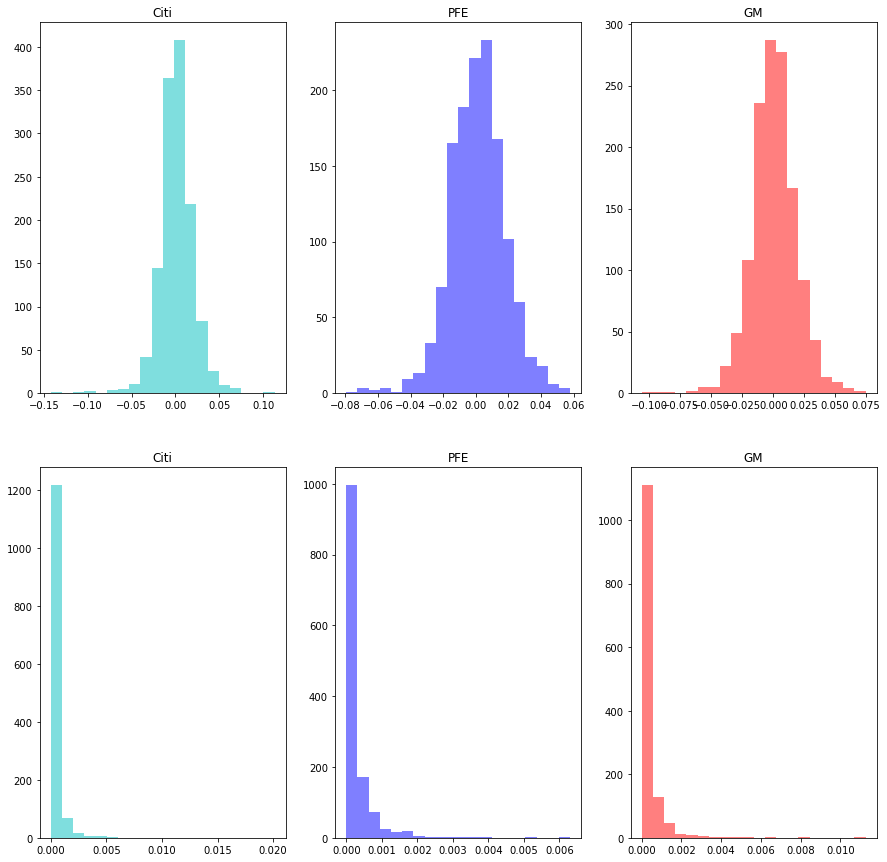

In [8]:
#Plot histograms of returns and squared returns
num_bins = 20
colors = ['c','b','r']

fig, axs = plt.subplots(2, len(stocks), figsize = (15,15))

for idx, i in enumerate(stocks):
    axs[0][idx].hist(logRet[i], num_bins, alpha = 0.5, color = colors[idx])
    axs[0][idx].set_title(i)
    
for idx, i in enumerate(stocks):
    axs[1][idx].hist(logRet[i]**2, num_bins, alpha = 0.5, color = colors[idx])
    axs[1][idx].set_title(i)
    
plt.show()

As we can see, the squared returns are mostly very close to zero, but there are some severe outliers that kind of "messes" up the histogram plotting. Most of the values are in the (0,1e-2) or even tighter, but a tiny few outliers keep the range of the plot much wider. I.e., returns are heavy-tailed. This confirms our excess kurtosis estimates. 

In [33]:
#Let's compute the JB statistic, and then run hypothesis tests for normality on each

JBStat = dict()

for i in stocks:
    JBStat[i] = (logRet.shape[0]/6)*(sampleSkew[i]**2 + 0.25*(sampleEKur[i]**2))

#Calculate the critical value for this test given n, our number of observations
alpha = 0.05 #i.e. a 95 confidence interval
cValue = chi2.ppf(1 - alpha, df=2)

#conduct the hypothesis test
Normality = {key: (True if val <= cValue else False) for (key, val) in JBStat.items()}
  
print(JBStat)
print(Normality)

{'Citi': 1749.7137263009568, 'PFE': 145.17005580917822, 'GM': 302.2250582159513}
{'Citi': False, 'PFE': False, 'GM': False}


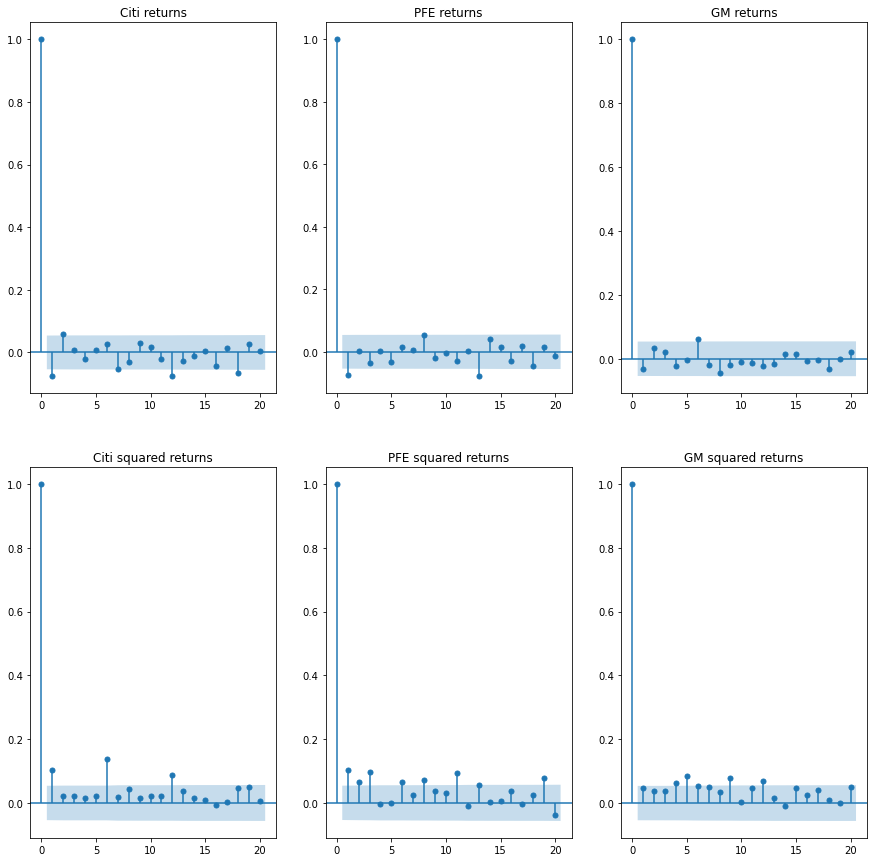

In [57]:
#Plot ACF's of returns and squared returns
colors = ['c','b','r']

fig, axs = plt.subplots(2, len(stocks), figsize = (15,15))

for idx, i in enumerate(stocks):
    sm.graphics.tsa.plot_acf(logRet[i], lags=20, ax = axs[0][idx])
    axs[0][idx].set_title(i + " returns")
    
for idx, i in enumerate(stocks):
    sm.graphics.tsa.plot_acf(logRet[i]**2, lags=20, ax = axs[1][idx])
    axs[1][idx].set_title(i + " squared returns")
    
plt.show()

As we can see, the squared returns have clear significant lags as we would expect from volatility clustering. For the returns themselves, some series have 1 significant lag, but at the 95% critical value we would expect that 1 in 20 would be significant just by probability, thus its pretty hard to say that returns themselves have autocorrelation, except maybe Citi's case.